# Compare REM and HAND approaches

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import py3dep
import rasterio
import rioxarray
from pynhd import NHD, prepare_nhdplus
import whitebox
from shapely import box
import xrspatial
import pysheds
from pysheds.grid import Grid
import shapely

import os

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
aoi = box(-119.865551,34.005791,-119.785711,34.040756)

nhd = NHD('flowline_mr')

dem = py3dep.get_map("DEM", aoi, resolution=10, geo_crs=4326, crs=4326)
flow = nhd.bygeom(aoi, geo_crs=4326)

In [4]:
dem = dem.rio.reproject(3310)
flow = flow.to_crs(3310)

In [7]:
flow.to_file('streams.geojson')

In [6]:
dem.rio.to_raster('dem.tif')

In [4]:
slope = xrspatial.slope(dem)
curvature = xrspatial.curvature(dem)
hillshade = xrspatial.hillshade(dem, angle_altitude=45, azimuth=225)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:23: RuntimeWarning: invalid value encountered in sin
  shaded = np.sin(altituderad) * np.sin(slope) + \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:24: RuntimeWarning: invalid value encountered in cos
  np.cos(altituderad) * np.cos(slope) * \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:25: RuntimeWarning: invalid value encountered in cos
  np.cos((azimuthrad - np.pi/2.) - aspect)


In [5]:
def xarrayrio_to_pysheds(xarr):
    xarr.rio.to_raster('temp.tif')
    grid = Grid.from_raster('temp.tif')
    raster = grid.read_raster('temp.tif')
    os.remove('temp.tif')
    return grid,raster

In [6]:
# split into subbasins
# get coordinates of end of each segment
# for each coordinate get upstream basin
# for each basin, get difference with all other basins to get subbasin
grid, pysheds_dem = xarrayrio_to_pysheds(dem)

In [7]:
# get coordinates of start and end of each flowline
# keep only the one with the lowest elevation
def get_pour_point(flowline, dem):
    start_point = flowline.coords[0]
    end_point = flowline.coords[-1]
    elev_start_point = dem.sel(x=start_point[0], y=start_point[1], method='nearest').values.item()
    elev_end_point = dem.sel(x=end_point[0], y=end_point[1], method='nearest').values.item()

    if elev_start_point > elev_end_point:
        return shapely.Point(end_point)
    else:
        return shapely.Point(start_point)


In [9]:
# clip each line to the bounds and get pour points
flow['geometry'] = flow['geometry'].apply(lambda x: x.intersection(box(*grid.bbox)))
pour_points = gpd.GeoSeries([get_pour_point(line, dem=dem) for line in flow['geometry']], index=flow.index)
pour_points

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


0     POINT (16285.965 -442275.449)
1     POINT (13094.807 -444143.381)
2     POINT (12414.627 -443690.391)
3     POINT (18450.362 -443262.660)
4     POINT (12414.627 -444941.626)
5     POINT (19483.448 -444929.339)
6     POINT (15802.719 -445320.321)
7     POINT (17032.748 -442558.777)
8     POINT (18731.367 -441623.758)
9     POINT (12414.627 -444158.482)
10    POINT (12482.558 -443831.910)
11    POINT (13094.807 -444143.381)
12    POINT (16385.006 -444133.834)
13    POINT (15802.719 -445320.321)
14    POINT (14028.842 -443984.709)
15    POINT (12482.558 -443831.910)
16    POINT (14028.842 -443984.709)
17    POINT (12993.305 -444176.506)
18    POINT (16998.086 -445510.884)
19    POINT (12996.192 -441623.758)
20    POINT (19799.166 -441645.334)
21    POINT (12414.627 -443807.106)
22    POINT (12993.305 -444176.506)
23    POINT (14809.632 -443161.030)
24    POINT (14295.512 -444065.593)
25    POINT (15526.612 -443916.654)
26    POINT (14809.632 -443161.030)
27    POINT (15526.612 -4439

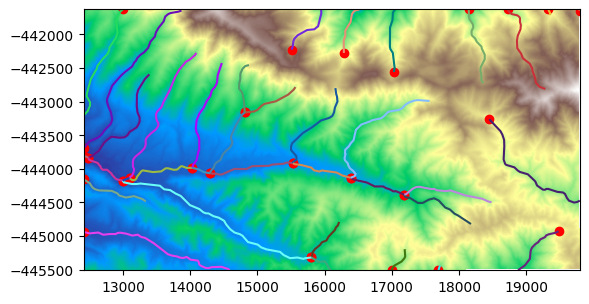

In [10]:
fig, ax = plt.subplots()
colors = [tuple(c) for c in np.random.rand(len(flow['geometry']), 3)]
flow['geometry'].plot(ax=ax, color=colors)
pour_points.plot(ax=ax, color='red')
plt.imshow(pysheds_dem, cmap="terrain", extent=grid.extent)

In [11]:
def compute_flow_dir(grid, dem, dirmap):
    inflated_dem = grid.resolve_flats(dem)
    fdir = grid.flowdir(inflated_dem, dirmap = dirmap)
    return fdir
    
def get_catchment_polygon(pour_point, flow_acc, flow_dir, dirmap):
    x,y = (pour_point.x, pour_point.y)
    x_snap, y_snap = grid.snap_to_mask(flow_acc > 10, (x,y))
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=flow_dir, dirmap = dirmap, xytype='coordinate')
    catchment_geo = grid.polygonize(catch)
    return catchment_geo

In [ ]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
flow_dir = compute_flow_dir(grid, pysheds_dem, dirmap=dirmap)
flow_acc = grid.accumulation(flow_dir, dirmap = dirmap)

for point in pour_points[25:33]:
    print(point)
    catch = get_catchment_polygon(point, flow_acc, flow_dir, dirmap)

POINT (15526.611627084118 -443916.6544107641)
POINT (14809.6317669891 -443161.02991217887)
POINT (15526.611627084118 -443916.6544107641)
POINT (14295.512104468582 -444065.59318530234)


In [ ]:
fig, ax = plt.subplots()
colors = [tuple(c) for c in np.random.rand(len(flow['geometry']), 3)]
flow['geometry'].plot(ax=ax, color=colors)
flow['pour_point'].iloc[2:3].plot(ax=ax, color='red')
#plt.imshow(pysheds_dem, cmap="terrain", extent=grid.extent)
plt.imshow(flow_dir, extent=grid.extent)
ax.imshow(np.where(catch, catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')